In [25]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import cv2
import sys
import math
from pathlib import Path
PIPELINE_ROOT = Path('./').resolve().parent.parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())
print(PIPELINE_ROOT)

from src.library.utilities.utilities_process import read_image, write_image

/home/eddyod/programming/pipeline


In [26]:
def show_image(img, increaser=1, _title="", fsize=[15,15]):
    plt.figure(figsize=[15,15])
    plt.imshow(img * increaser, cmap="gray")
    plt.title(_title,fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()

def collect_positives(uimg, startr, startc, tile_width, tile_height):
    img=np.copy(uimg)
    positives=[]
    radius = 80
    a=int(radius/2)
    color = (65000)
    min_row,min_col = startr, startc
    for index,r in df.iterrows():
        col = int(round(r['x'])-min_col)
        row = int(round(r['y'])-min_row)
        if (col<0) or (col>tile_width) or (row<0) or (row>tile_height):
            continue
        img=cv2.circle(img, (int(col), int(row)), radius, color, 20)
        I=uimg[row-a:row+a,col-a:col+a]
        if I.shape==(radius,radius):
            positives.append((col,row,I))

    return img,positives



In [27]:
animal = 'DK184'
section = 57
channel = 3
prep_path = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'

In [28]:
tif = str(section).zfill(3) + ".tif"
filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
full_img = read_image(filepath)
full_img.shape

(38835, 77383)

In [ ]:
resize = True
if resize:
    filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
    startr = 6000
    endr = 25000
    startc = 35000
    endc = 65000
    img = full_img[startr:endr, startc:endc]
    print(img.shape)
    write_image(filepath, img)

In [29]:
dfpath = os.path.join(prep_path, 'cell_labels', 'all_predictions.csv')
df = pd.read_csv(dfpath)
df = df.loc[df['section'] == section]
df = df.sort_values(['section', 'x', 'y'])

In [30]:
print(df.head(3))
print(df.tail(3))

         x        y  section
0  44489.0  13942.0       57
1  44595.0  14804.0       57
2  44751.0  15170.0       57
           x        y  section
120  62624.0  18009.0       57
121  62763.0  18247.0       57
122  62827.0  18360.0       57


In [31]:
count = len(df.index)
if count > 100:
    lower = count // 4
    upper = lower + 100
    print(lower, upper)
    df = df[lower:upper]
print(len(df.index))

30 130
93


In [32]:
startc = int(round(min(df['x']), -3)) - 1000
startr = int(round(min(df['y']), -3)) - 1000
endc = math.ceil(max(df['x'])) + 100
endr = math.ceil(max(df['y'])) + 100
# manually set to ROI
#startr = 0
#endr = startr + 0
#startc = 0
#endc = startc + 15000
print(startr, endr, startc, endc)

6000 24390 50000 62927


In [33]:
tile_width = endc - startc
tile_height = endr - startr
img = full_img[startr:endr, startc:endc]
print(f'{startr}:{endr}, {startc}:{endc}')
print(img.shape)
#img.shape # (6800, 30000)

6000:24390, 50000:62927
(18390, 12927)


In [34]:
annotated_img, positives = collect_positives(img, startr, startc, tile_width, tile_height)
print(len(positives))

93


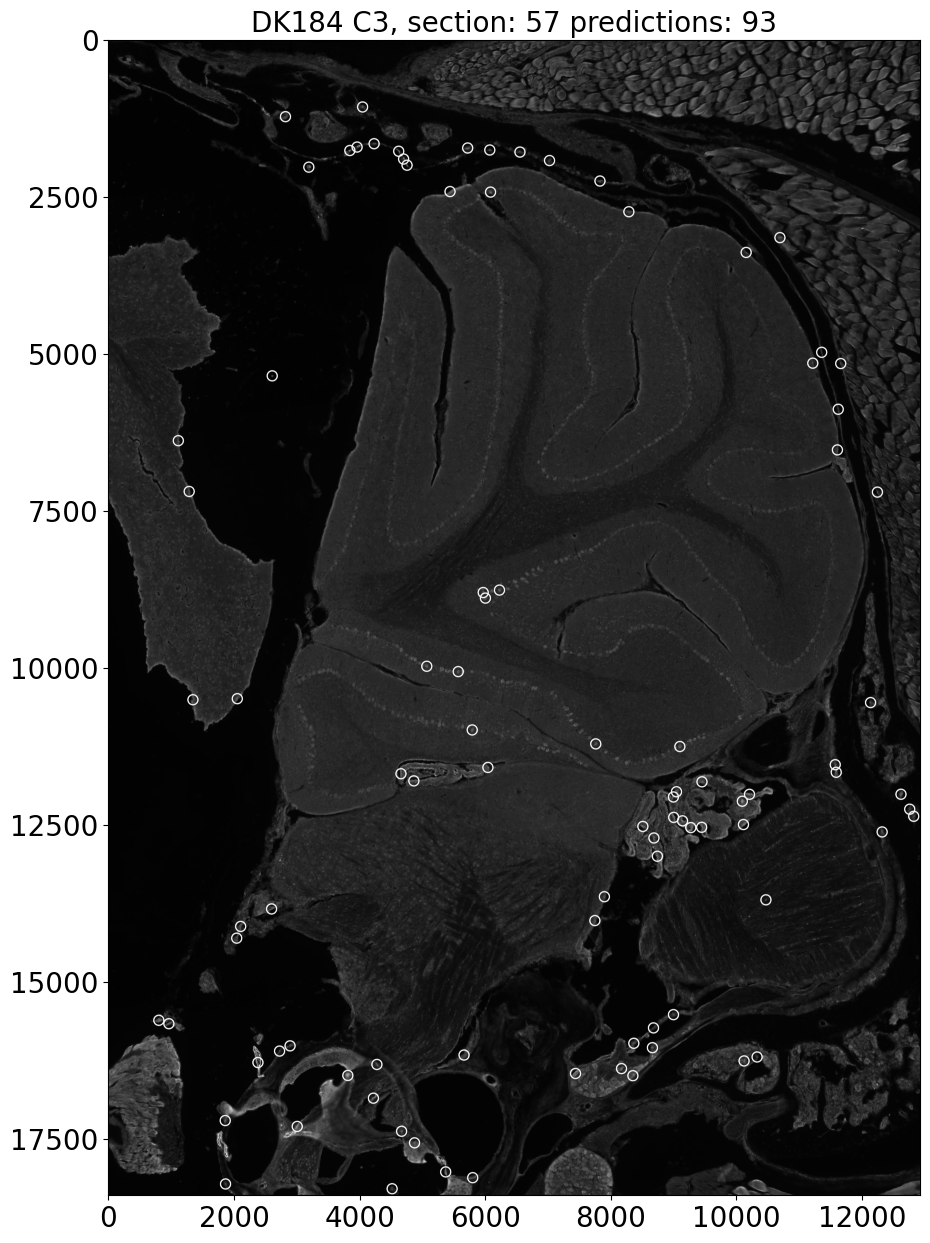

In [35]:
#vimg=annotated_img[in_row_min:in_row_max, in_col_min: in_col_max]
increaser = 4
show_image(annotated_img, increaser=increaser,_title=f'{animal} C{channel}, section: {section} predictions: {len(positives)}')

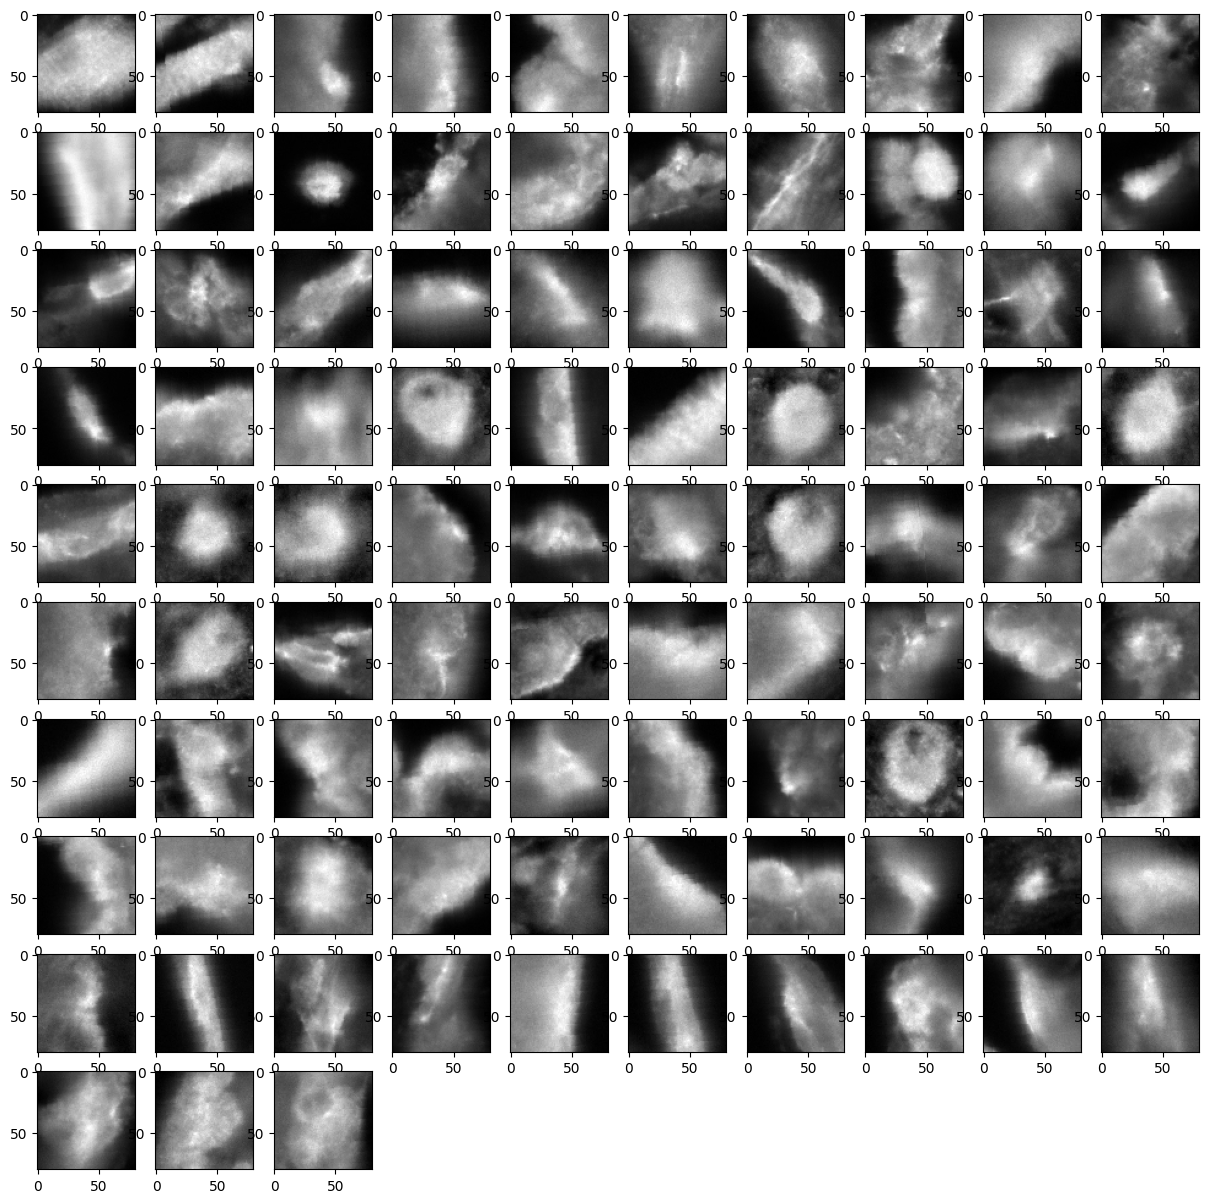

In [36]:
plt.figure(figsize=[15,15])
end = min(100, len(positives))
for i in range(len(positives[0:end])):
    plt.subplot(10,10,i+1)
    plt.imshow(positives[i][2], cmap="gray")
plt.show()

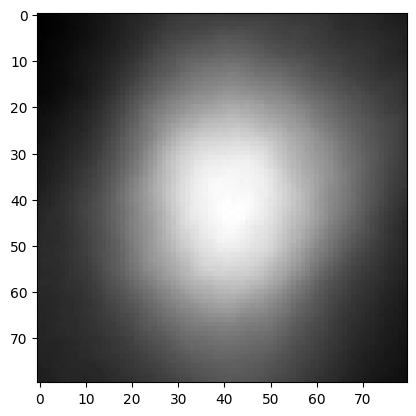

before: mean=3382.73 std=1010.05
after: mean= 0.00 std= 1.00


In [37]:
S=np.stack([I for (x,y,I)in positives])
S.shape

Mean=np.mean(S,axis=0)
Mean.shape

plt.imshow(Mean, cmap="gray")
plt.show()

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
print('before: mean=%5.2f std=%5.2f'%(_mean,_std))

Mean = (Mean-_mean)/_std

_mean=np.mean(Mean.flatten())
_std=np.std(Mean.flatten())
print('after: mean=%5.2f std=%5.2f'%(_mean,_std))

import pickle as pk
with open('mean.pkl','wb') as pkl_file:
    pk.dump({'Mean':Mean},pkl_file)

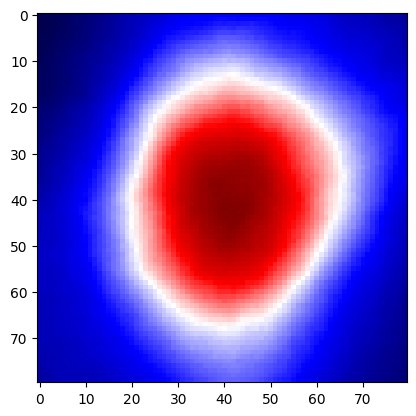

In [38]:
new_mean = cv2.normalize(Mean, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
plt.imshow(new_mean, cmap="seismic")
plt.show()